In [1]:
#libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, validation_curve
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import (classification_report, confusion_matrix, roc_curve,
                             auc, accuracy_score, f1_score, precision_score, recall_score)
from sklearn.model_selection import learning_curve
from sklearn.metrics import roc_curve, auc

In [2]:
# Load dataset
data = pd.read_csv('diabetes_012_health_indicators_BRFSS2015.csv')
data.head()

,Diabetes_012,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,1.0,1.0,40.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,5.0,18.0,15.0,1.0,0.0,9.0,4.0,3.0
1,0.0,0.0,0.0,0.0,25.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,3.0,0.0,0.0,0.0,0.0,7.0,6.0,1.0
2,0.0,1.0,1.0,1.0,28.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,5.0,30.0,30.0,1.0,0.0,9.0,4.0,8.0
3,0.0,1.0,0.0,1.0,27.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,0.0,0.0,0.0,0.0,11.0,3.0,6.0
4,0.0,1.0,1.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,3.0,0.0,0.0,0.0,11.0,5.0,4.0


In [3]:
# Step 1: Data Cleaning and Visualization
# Encode categorical columns if present
for col in data.columns:
    if data[col].dtype == 'object':
        data[col] = LabelEncoder().fit_transform(data[col])

In [4]:
data.dropna(inplace=True)
data.drop_duplicates(inplace=True)

In [5]:
def detect_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
    return outliers

outliers_summary = {}
for column in data.select_dtypes(include=['float64', 'int64']).columns:
    outliers = detect_outliers_iqr(data, column)
    outliers_summary[column] = len(outliers)
    print(f"Outliers in {column}: {len(outliers)}")

outliers_summary_df = pd.DataFrame(outliers_summary.items(), columns=['Column', 'Number of Outliers'])
print(outliers_summary_df)

Outliers in Diabetes_012: 39726
Outliers in HighBP: 0
Outliers in HighChol: 0
Outliers in CholCheck: 9298
Outliers in BMI: 5638
Outliers in Smoker: 0
Outliers in Stroke: 10284
Outliers in HeartDiseaseorAttack: 23717
Outliers in PhysActivity: 0
Outliers in Fruits: 0
Outliers in Veggies: 47148
Outliers in HvyAlcoholConsump: 13950
Outliers in AnyHealthcare: 12391
Outliers in NoDocbcCost: 21326
Outliers in GenHlth: 12078
Outliers in MentHlth: 36163
Outliers in PhysHlth: 34347
Outliers in DiffWalk: 42626
Outliers in Sex: 0
Outliers in Age: 0
Outliers in Education: 0
Outliers in Income: 0
                  Column  Number of Outliers
0           Diabetes_012               39726
1                 HighBP                   0
2               HighChol                   0
3              CholCheck                9298
4                    BMI                5638
5                 Smoker                   0
6                 Stroke               10284
7   HeartDiseaseorAttack               23717
8    

In [6]:
# handle outliers
#choosing bmi is due the fact that Extremely high or low BMI values are uncommon in healthy populations
#and among the columns that has outliers it is the only continuous one
Q1 = data['BMI'].quantile(0.25)
Q3 = data['BMI'].quantile(0.75)
IQR = Q3 - Q1
upper_limit = Q3 + 1.5 * IQR
data['BMI'] = data['BMI'].apply(lambda x: upper_limit if x > upper_limit else x)


<ipython-input-6-b6911aab77bb>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Diabetes_012', data=data, palette='viridis')


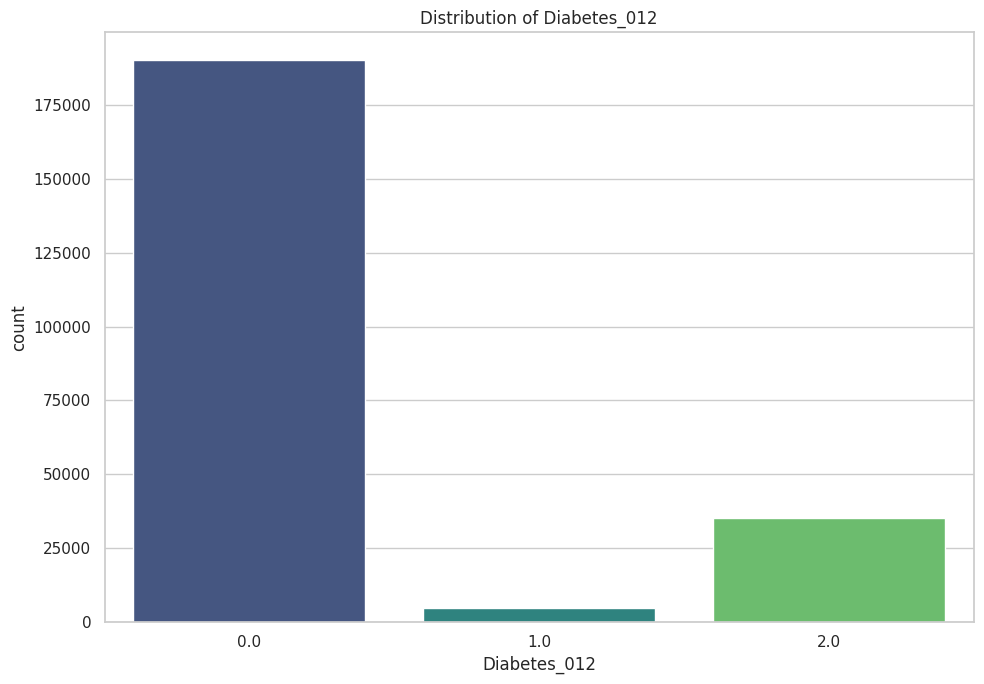

In [6]:
# Visualizations
# Countplot of Diabetes_012 to show the distribution of the target variable
sns.set(style="whitegrid")

plt.figure(figsize=(10, 7))
sns.countplot(x='Diabetes_012', data=data, palette='viridis')
plt.title('Distribution of Diabetes_012')

plt.tight_layout()
plt.show()

<Figure size 1000x600 with 0 Axes>

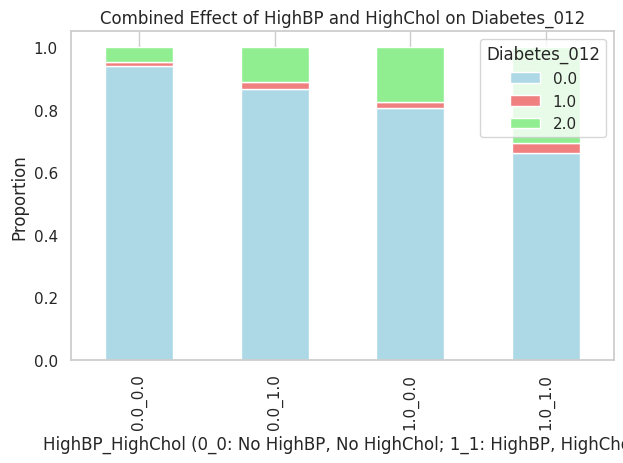

In [7]:
# Combined Effect of High BP and High Cholestrol on diabetes
data_copy = data.copy()

data_copy['HighBP_HighChol'] = data_copy['HighBP'].astype(str) + "_" + data_copy['HighChol'].astype(str)

plt.figure(figsize=(10, 6))

bp_chol_diabetes_relation = pd.crosstab(data_copy['HighBP_HighChol'], data_copy['Diabetes_012'], normalize='index')

bp_chol_diabetes_relation.plot(kind='bar', stacked=True, color=['lightblue', 'lightcoral', 'lightgreen'])

plt.title('Combined Effect of HighBP and HighChol on Diabetes_012')
plt.xlabel('HighBP_HighChol (0_0: No HighBP, No HighChol; 1_1: HighBP, HighChol)')
plt.ylabel('Proportion')
plt.legend(title='Diabetes_012')
plt.grid(axis='y')

# Show the plot
plt.tight_layout()
plt.show()


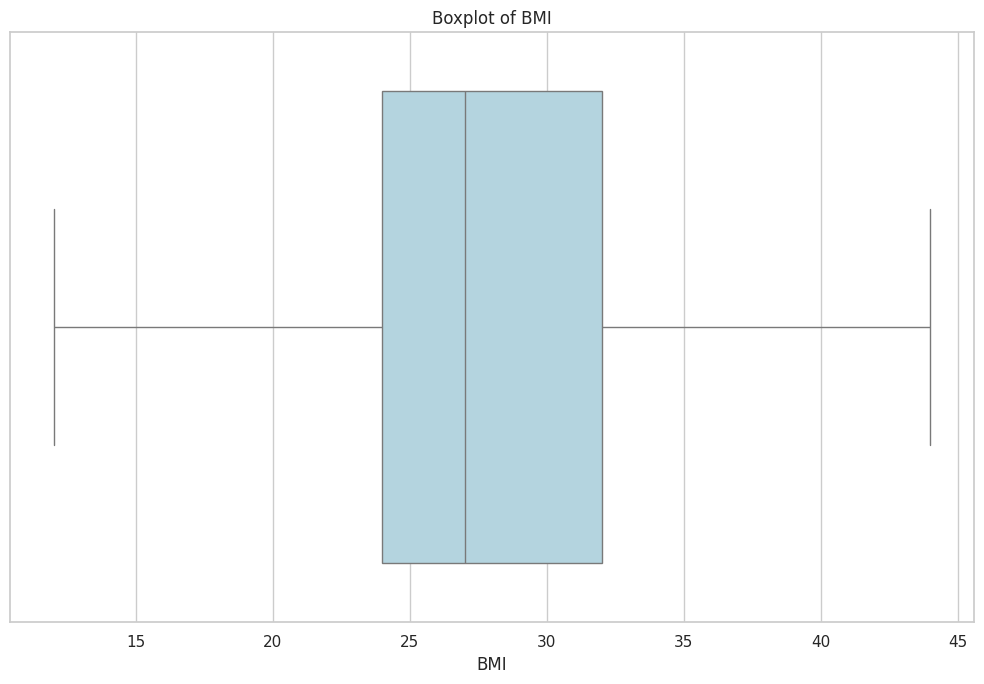

In [8]:
# Boxplot of BMI to visualize the spread of BMI values and potential outliers
plt.figure(figsize=(10, 7))
sns.boxplot(x='BMI', data=data, color='lightblue')
plt.title('Boxplot of BMI')

plt.tight_layout()
plt.show()

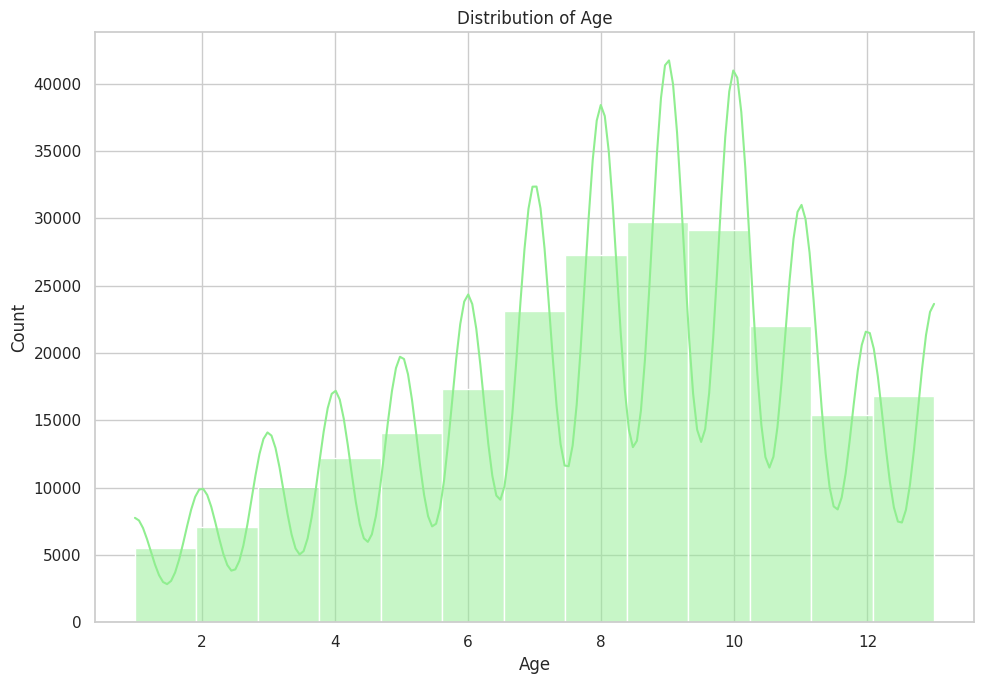

In [9]:
# Histogram of Age to visualize the distribution of the Age variable
plt.figure(figsize=(10, 7))
sns.histplot(data['Age'], bins=13, kde=True, color='lightgreen')
plt.title('Distribution of Age')

plt.tight_layout()
plt.show()

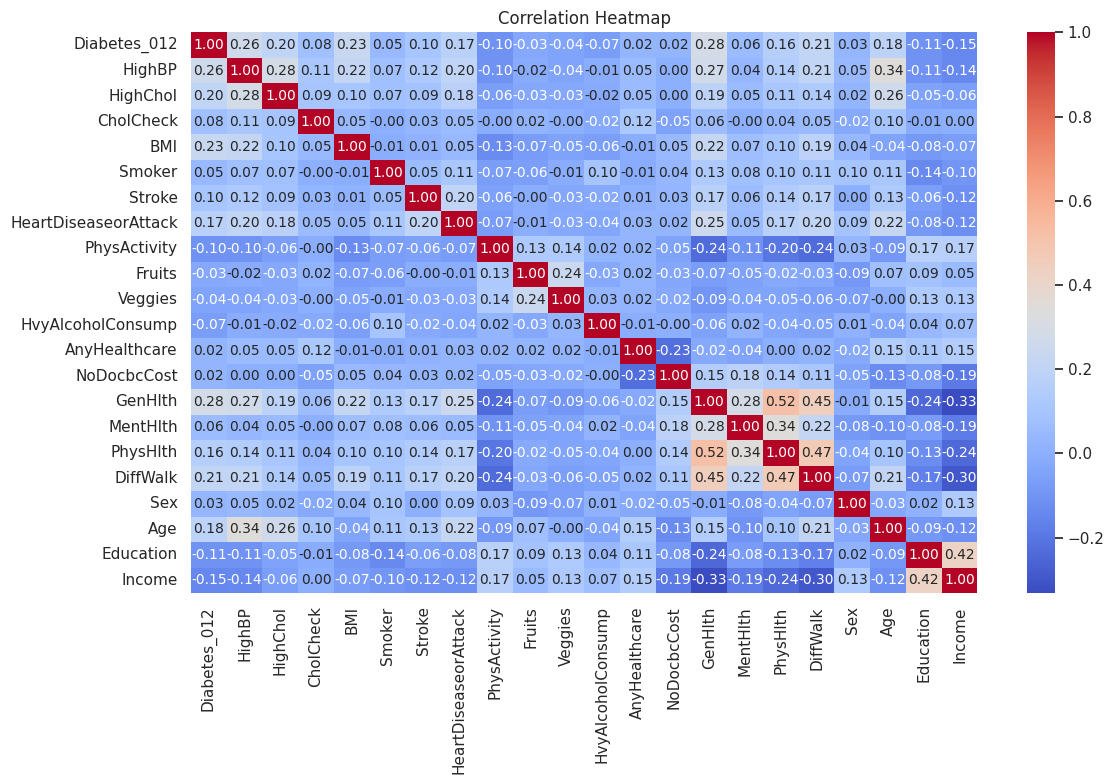

In [13]:
# Correlation heatmap to visualize correlations between numerical features
plt.figure(figsize=(12, 8))
corr_matrix = data.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', annot_kws={'size': 10})

plt.title('Correlation Heatmap')

plt.tight_layout()
plt.show()

In [9]:
# Step 2: Train-test split
X = data.drop('Diabetes_012', axis=1)
y = data['Diabetes_012']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [10]:
# Step 3: Standardization
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [11]:
# Step 4: Feature Selection (before and after)
# Before feature selection with a different score function
selector = SelectKBest(score_func=f_classif, k=10)
X_train_selected = selector.fit_transform(X_train_scaled, y_train)
X_test_selected = selector.transform(X_test_scaled)


In [12]:
# Step 5: Implement 3 models and hyperparameter tuning for each
# Logistic Regression training and hyperparameter tuning
print("\nHyperparameter Tuning for Logistic Regression...")
log_reg = LogisticRegression(max_iter=1000)
param_grid_log_reg = {'C': [0.01, 0.1, 1, 10, 100]}

grid_search_log_reg = GridSearchCV(log_reg, param_grid_log_reg, cv=3, scoring='accuracy', n_jobs=-1)
grid_search_log_reg.fit(X_train_scaled, y_train)

best_log_reg = grid_search_log_reg.best_estimator_
print("Best Logistic Regression Model:", best_log_reg)



Hyperparameter Tuning for Logistic Regression...
Best Logistic Regression Model: LogisticRegression(C=1, max_iter=1000)


In [13]:
# K-Nearest Neighbors training and hyperparameter tuning
print("\nHyperparameter Tuning for K-Nearest Neighbors...")
knn = KNeighborsClassifier()
param_grid_knn = {'n_neighbors': [3, 5, 7, 9, 11], 'weights': ['uniform', 'distance']}

grid_search_knn = GridSearchCV(knn, param_grid_knn, cv=3, scoring='accuracy', n_jobs=-1)
grid_search_knn.fit(X_train_scaled, y_train)

best_knn = grid_search_knn.best_estimator_
print("Best K-Nearest Neighbors Model:", best_knn)



Hyperparameter Tuning for K-Nearest Neighbors...
Best K-Nearest Neighbors Model: KNeighborsClassifier(n_neighbors=11)


/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


In [14]:
# Decision Tree training and hyperparameter tuning
print("\nHyperparameter Tuning for Decision Tree...")
decision_tree = DecisionTreeClassifier()
param_grid_decision_tree = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search_decision_tree = GridSearchCV(decision_tree, param_grid_decision_tree, cv=3, scoring='accuracy', n_jobs=-1)
grid_search_decision_tree.fit(X_train_scaled, y_train)

best_decision_tree = grid_search_decision_tree.best_estimator_
print("Best Decision Tree Model:", best_decision_tree)



Hyperparameter Tuning for Decision Tree...
Best Decision Tree Model: DecisionTreeClassifier(criterion='entropy', max_depth=10, min_samples_leaf=4,
                       min_samples_split=10)


In [15]:
# Store the best models in a dictionary for evaluation and comparison
best_models = {
    'Logistic Regression': best_log_reg,
    'K-Nearest Neighbors': best_knn,
    'Decision Tree': best_decision_tree
}


Training Logistic Regression...


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Classification Report:
              precision    recall  f1-score   support

         0.0       0.87      0.97      0.92     64180
         1.0       0.00      0.00      0.00      1425
         2.0       0.53      0.19      0.28     10499

    accuracy                           0.85     76104
   macro avg       0.47      0.39      0.40     76104
weighted avg       0.80      0.85      0.81     76104



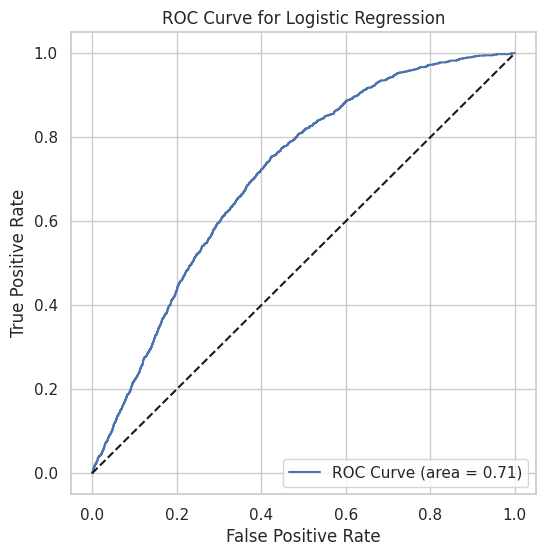

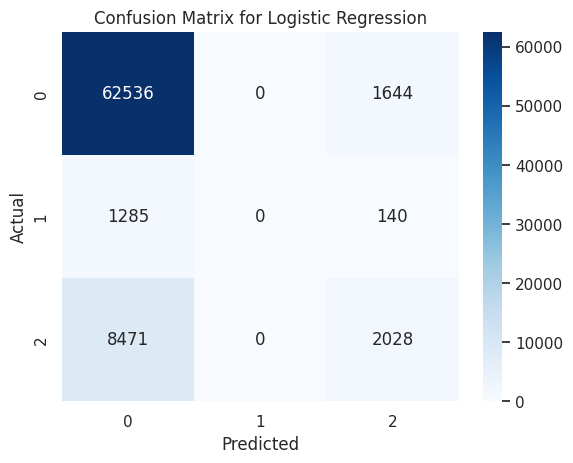

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Training K-Nearest Neighbors...


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Classification Report:
              precision    recall  f1-score   support

         0.0       0.86      0.97      0.91     64180
         1.0       0.00      0.00      0.00      1425
         2.0       0.46      0.17      0.25     10499

    accuracy                           0.84     76104
   macro avg       0.44      0.38      0.39     76104
weighted avg       0.79      0.84      0.80     76104



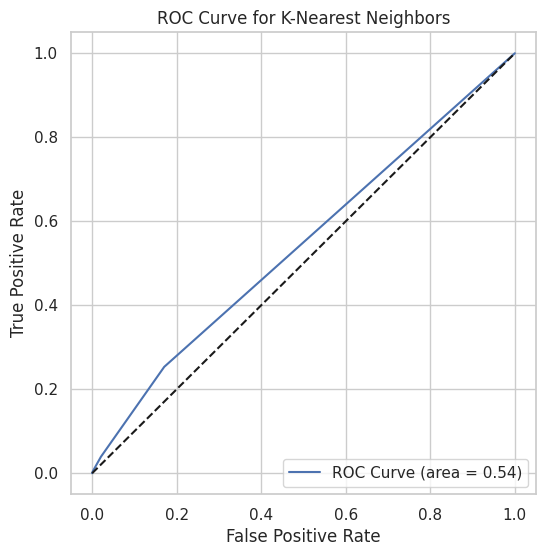

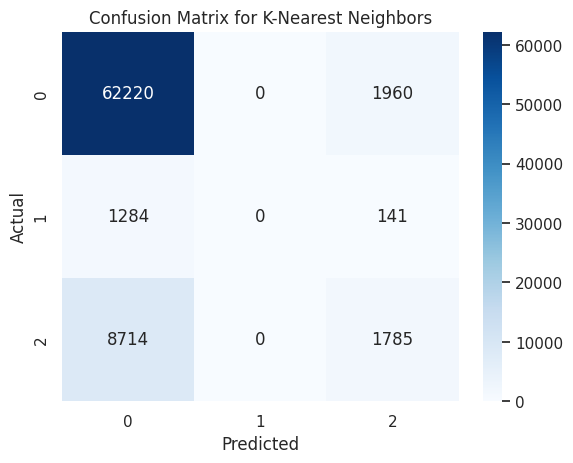

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Training Decision Tree...
Classification Report:
              precision    recall  f1-score   support

         0.0       0.87      0.97      0.91     64180
         1.0       0.00      0.00      0.00      1425
         2.0       0.50      0.20      0.28     10499

    accuracy                           0.85     76104
   macro avg       0.46      0.39      0.40     76104
weighted avg       0.80      0.85      0.81     76104



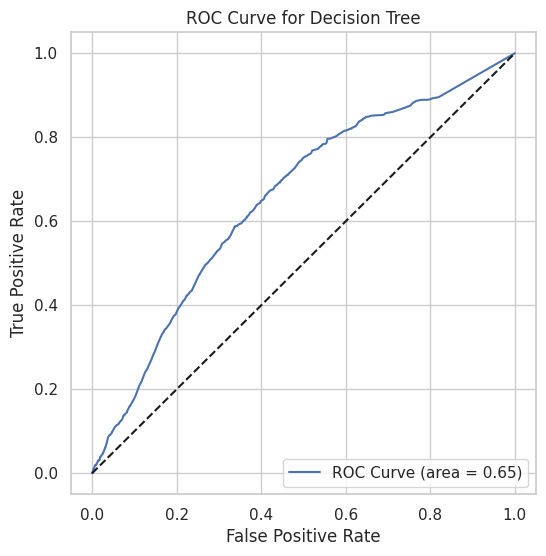

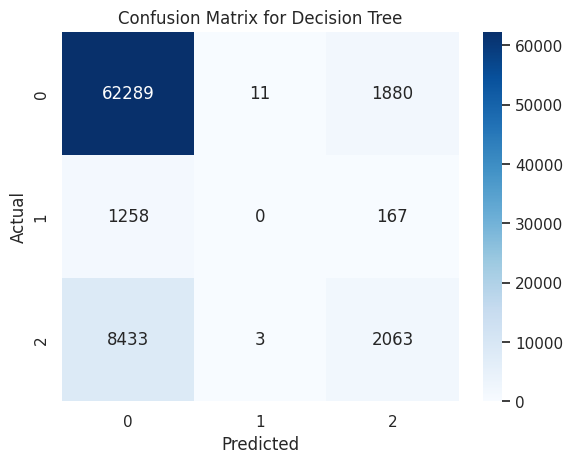

In [26]:
# Step 6: Train and evaluate models
results = {}
roc_data = {}
for model_name, model in best_models.items():
    print(f"\nTraining {model_name}...")
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    y_pred_proba = model.predict_proba(X_test_scaled)[:, 1] if hasattr(model, 'predict_proba') else None

    # Metrics and ROC curve
    conf_matrix = confusion_matrix(y_test, y_pred)
    class_report = classification_report(y_test, y_pred)
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba, pos_label=1) if y_pred_proba is not None else (None, None, None)
    roc_auc = auc(fpr, tpr) if y_pred_proba is not None else None

    # Display metrics
    print("Classification Report:")
    print(class_report)

    # Plot ROC curve
    if roc_auc is not None:
        plt.figure(figsize=(6, 6))
        plt.plot(fpr, tpr, label=f'ROC Curve (area = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve for {model_name}')
        plt.legend(loc='lower right')
        plt.show()
    # Store the ROC data for later plotting
    if roc_auc is not None:
       roc_data[model_name] = {
            'fpr': fpr,
            'tpr': tpr,
            'roc_auc': roc_auc
        }
    # Confusion matrix
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap='Blues')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    # Store results
    results[model_name] = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'F1 Score': f1_score(y_test, y_pred, average='weighted'),
        'Precision': precision_score(y_test, y_pred, average='weighted'),
        'Recall': recall_score(y_test, y_pred, average='weighted')
    }


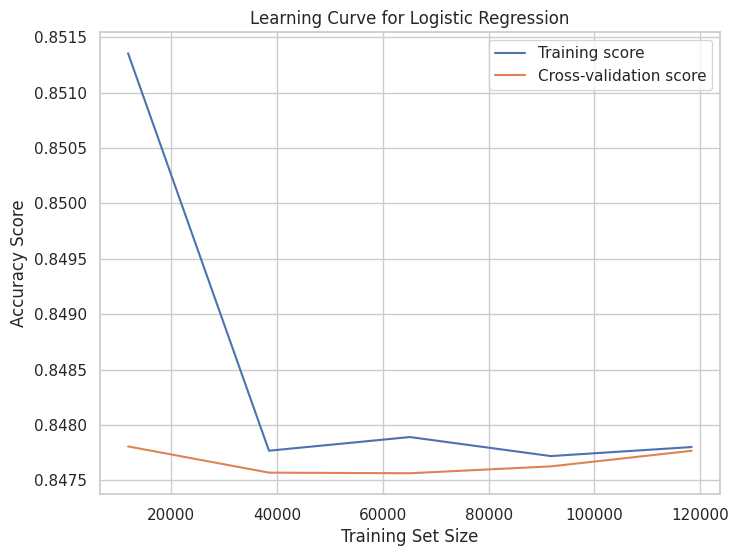

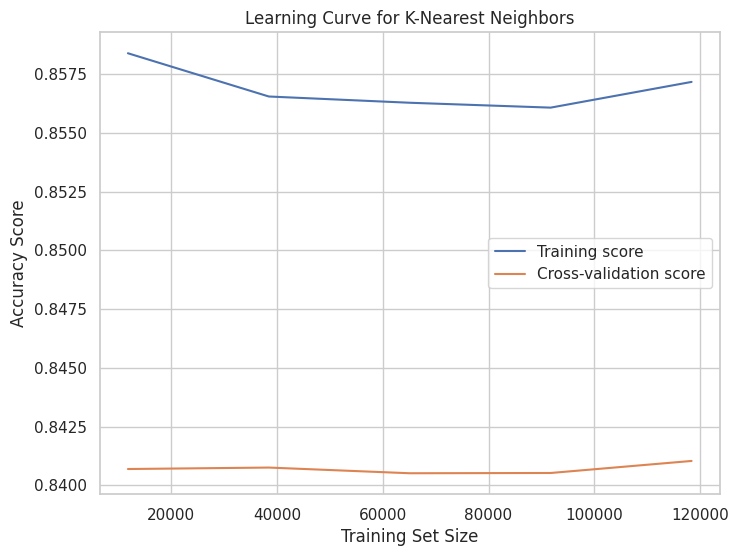

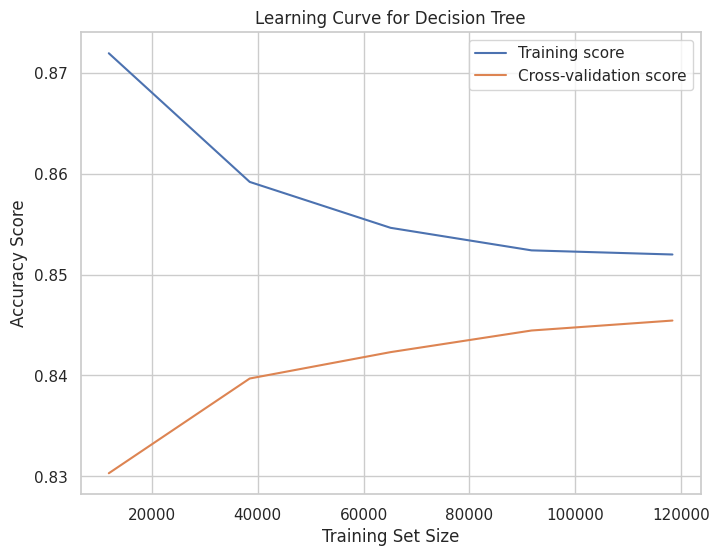

In [24]:
# Step 7: Drawing learning curves
for model_name, model in best_models.items():
    train_sizes, train_scores, test_scores = learning_curve(
        model, X_train_scaled, y_train, cv=3, scoring='accuracy', n_jobs=-1,
        train_sizes=np.linspace(0.1, 1.0, 5)
    )

    train_mean = np.mean(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)

    plt.figure(figsize=(8, 6))
    plt.plot(train_sizes, train_mean, label='Training score')
    plt.plot(train_sizes, test_mean, label='Cross-validation score')
    plt.title(f'Learning Curve for {model_name}')
    plt.xlabel('Training Set Size')
    plt.ylabel('Accuracy Score')
    plt.legend(loc='best')
    plt.show()

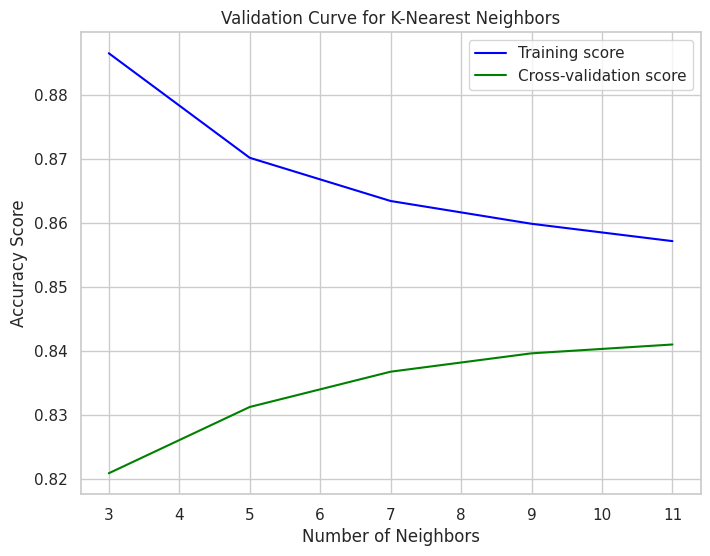

In [28]:
# Step 8: Parameter tuning curve (e.g., for KNN)
param_range = [3, 5, 7, 9, 11]
train_scores, test_scores = validation_curve(
    KNeighborsClassifier(), X_train_scaled, y_train,
    param_name="n_neighbors", param_range=param_range, cv=3, scoring="accuracy", n_jobs=-1
)

train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)

plt.figure(figsize=(8, 6))
plt.plot(param_range, train_mean, label="Training score", color="blue")
plt.plot(param_range, test_mean, label="Cross-validation score", color="green")
plt.title("Validation Curve for K-Nearest Neighbors")
plt.xlabel("Number of Neighbors")
plt.ylabel("Accuracy Score")
plt.legend(loc="best")
plt.show()

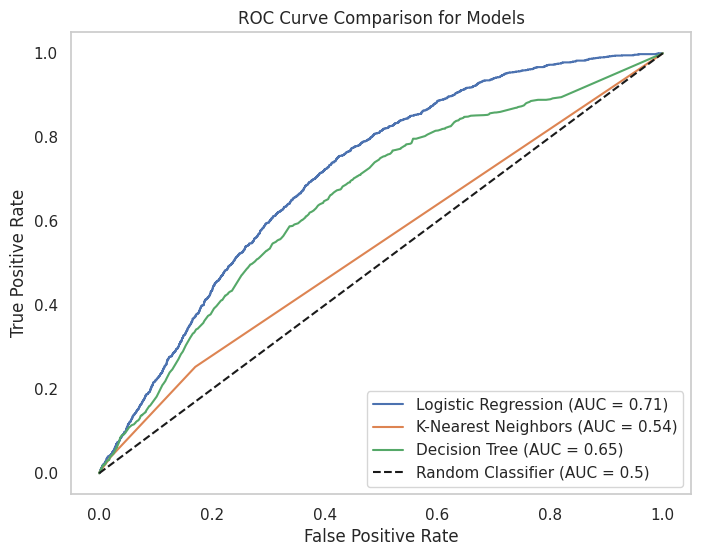

In [29]:
# Step 9: Comparison between models
# Create the ROC curve plot
plt.figure(figsize=(8, 6))

# Loop through the stored ROC data and plot each model's ROC curve
for model_name, data in roc_data.items():
    fpr = data['fpr']
    tpr = data['tpr']
    auc_score = data['roc_auc']

    # Plot ROC curve
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc_score:0.2f})')

# Plot the diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier (AUC = 0.5)')

# Add labels, title, and grid
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison for Models')
plt.legend(loc='lower right')
plt.grid()

# Show the plot
plt.show()

In [30]:
# Step 10: Comparison table
comparison_df = pd.DataFrame(results).T
print("\nModel Comparison:")
print(comparison_df)


Model Comparison:
                     Accuracy  F1 Score  Precision    Recall
Logistic Regression  0.848365  0.811973   0.802905  0.848365
K-Nearest Neighbors  0.841020  0.803623   0.789938  0.841020
Decision Tree        0.845580  0.810548   0.799026  0.845580
